# Imports & Drive Mount

In [ ]:
!pip install mahotas

from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import mahotas
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.2 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Path & Loading

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/PlantVillage"

classes = sorted(os.listdir(DATASET_PATH))
print("Classes:", classes)

images = []
labels = []

for cls in classes:
    folder = os.path.join(DATASET_PATH, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (128, 128))

        images.append(gray)
        labels.append(cls)

images = np.array(images)
labels = np.array(labels)

print("Total images:", len(images))


Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Total images: 2152


# Label Encoding

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

print("Class mapping:")
for i, c in enumerate(encoder.classes_):
    print(i, "→", c)


Class mapping:
0 → Potato___Early_blight
1 → Potato___Late_blight
2 → Potato___healthy


# Feature Extraction (STANDARDIZED)

In [ ]:
def extract_haralick(images):
    feats = []
    for img in images:
        feats.append(mahotas.features.haralick(img.astype(np.uint8)).mean(axis=0))
    return np.array(feats)


def extract_hog(images):
    feats = []
    for img in images:
        feats.append(
            hog(
                img,
                orientations=9,
                pixels_per_cell=(16, 16),
                cells_per_block=(2, 2),
                block_norm="L2-Hys",
                transform_sqrt=True
            )
        )
    return np.array(feats)


def extract_combined(images):
    return np.concatenate(
        [extract_hog(images), extract_haralick(images)],
        axis=1
    )


🔹 Same HOG parameters as tomato
🔹 Same Haralick logic
🔹 Same feature ordering → perfect comparability

# Prepare Feature Sets

In [ ]:
X_hog = extract_hog(images)
X_haralick = extract_haralick(images)
X_combined = extract_combined(images)

print("HOG shape:", X_hog.shape)
print("Haralick shape:", X_haralick.shape)
print("Combined shape:", X_combined.shape)


HOG shape: (2152, 1764)
Haralick shape: (2152, 13)
Combined shape: (2152, 1777)


# Models (IMBALANCE-AWARE)

In [ ]:
models = {
    "SVM": SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


# Cross-Validation Accuracy Extraction

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def get_cv_mean_accuracy(X, y, model):
    """
    Returns mean 5-fold CV accuracy for a given feature matrix and model.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    scores = cross_val_score(
        model,
        X_scaled,
        y,
        cv=skf,
        scoring="accuracy"
    )
    return scores.mean()


# Stratified 5-Fold CV + Scaling

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_feature_set(X, y, name):
    print(f"\n===== {name} FEATURES =====")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    preds = {}

    for model_name, model in models.items():
        y_pred = cross_val_predict(model, X_scaled, y, cv=skf)
        preds[model_name] = y_pred

        print(f"\n--- {model_name} ---")
        print(classification_report(y, y_pred, target_names=encoder.classes_))

    return preds


# RUN EVALUATION

In [ ]:
preds_hog = evaluate_feature_set(X_hog, y, "HOG")
preds_haralick = evaluate_feature_set(X_haralick, y, "HARALICK")
preds_combined = evaluate_feature_set(X_combined, y, "HARALICK + HOG")



===== HOG FEATURES =====

--- SVM ---
                       precision    recall  f1-score   support

Potato___Early_blight       0.92      0.91      0.91      1000
 Potato___Late_blight       0.84      0.93      0.89      1000
     Potato___healthy       0.96      0.32      0.48       152

             accuracy                           0.88      2152
            macro avg       0.91      0.72      0.76      2152
         weighted avg       0.89      0.88      0.87      2152


--- Random Forest ---
                       precision    recall  f1-score   support

Potato___Early_blight       0.88      0.87      0.87      1000
 Potato___Late_blight       0.78      0.90      0.83      1000
     Potato___healthy       1.00      0.03      0.06       152

             accuracy                           0.82      2152
            macro avg       0.88      0.60      0.59      2152
         weighted avg       0.84      0.82      0.80      2152


--- KNN ---
                       precision    r

# Confusion Matrices

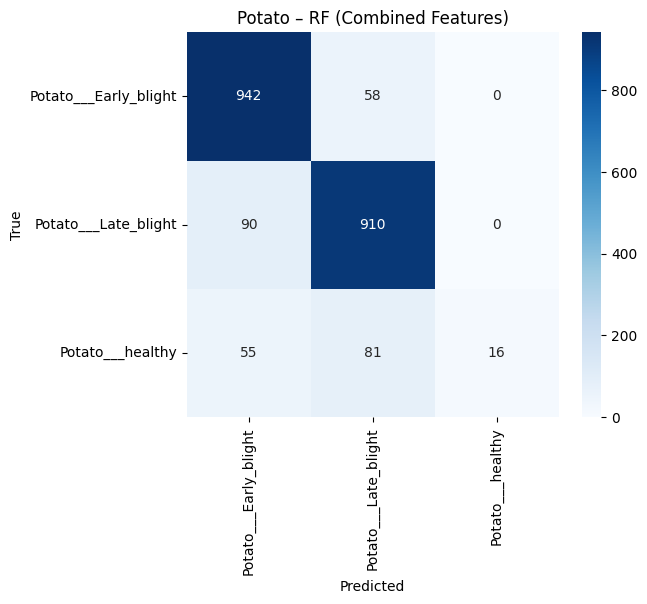

In [ ]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                cmap="Blues",
                xticklabels=encoder.classes_,
                yticklabels=encoder.classes_)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


plot_cm(y, preds_combined["Random Forest"], "Potato – RF (Combined Features)")


# Build Results Dictionary

In [ ]:
results_potato = {
    "Haralick": {},
    "HOG": {},
    "Haralick + HOG": {}
}

for model_name, model in models.items():
    results_potato["Haralick"][model_name] = get_cv_mean_accuracy(
        X_haralick, y, model
    )

    results_potato["HOG"][model_name] = get_cv_mean_accuracy(
        X_hog, y, model
    )

    results_potato["Haralick + HOG"][model_name] = get_cv_mean_accuracy(
        X_combined, y, model
    )

results_potato


{'Haralick': {'SVM': np.float64(0.8559564020935628),
  'Random Forest': np.float64(0.8643177035558193),
  'KNN': np.float64(0.8522354718610048)},
 'HOG': {'SVM': np.float64(0.8801197863270922),
  'Random Forest': np.float64(0.823891436896347),
  'KNN': np.float64(0.8187783952948793)},
 'Haralick + HOG': {'SVM': np.float64(0.9149711325743268),
  'Random Forest': np.float64(0.8680418712566773),
  'KNN': np.float64(0.8322581341391032)}}

# Save Results

In [ ]:
import json

# Save locally (runtime)
with open("results_potato.json", "w") as f:
    json.dump(results_potato, f)

# Copy to Google Drive (persistent storage)
!cp results_potato.json /content/drive/MyDrive/

print("results_potato.json saved to Drive")


results_potato.json saved to Drive


In [ ]:
import numpy as np

np.save("X_potato_combined.npy", X_combined)
np.save("y_potato.npy", y)

!cp X_potato_combined.npy /content/drive/MyDrive/
!cp y_potato.npy /content/drive/MyDrive/

In [ ]:
!ls /content/drive/MyDrive | grep potato

results_potato.json
X_potato_combined.npy
y_potato.npy
